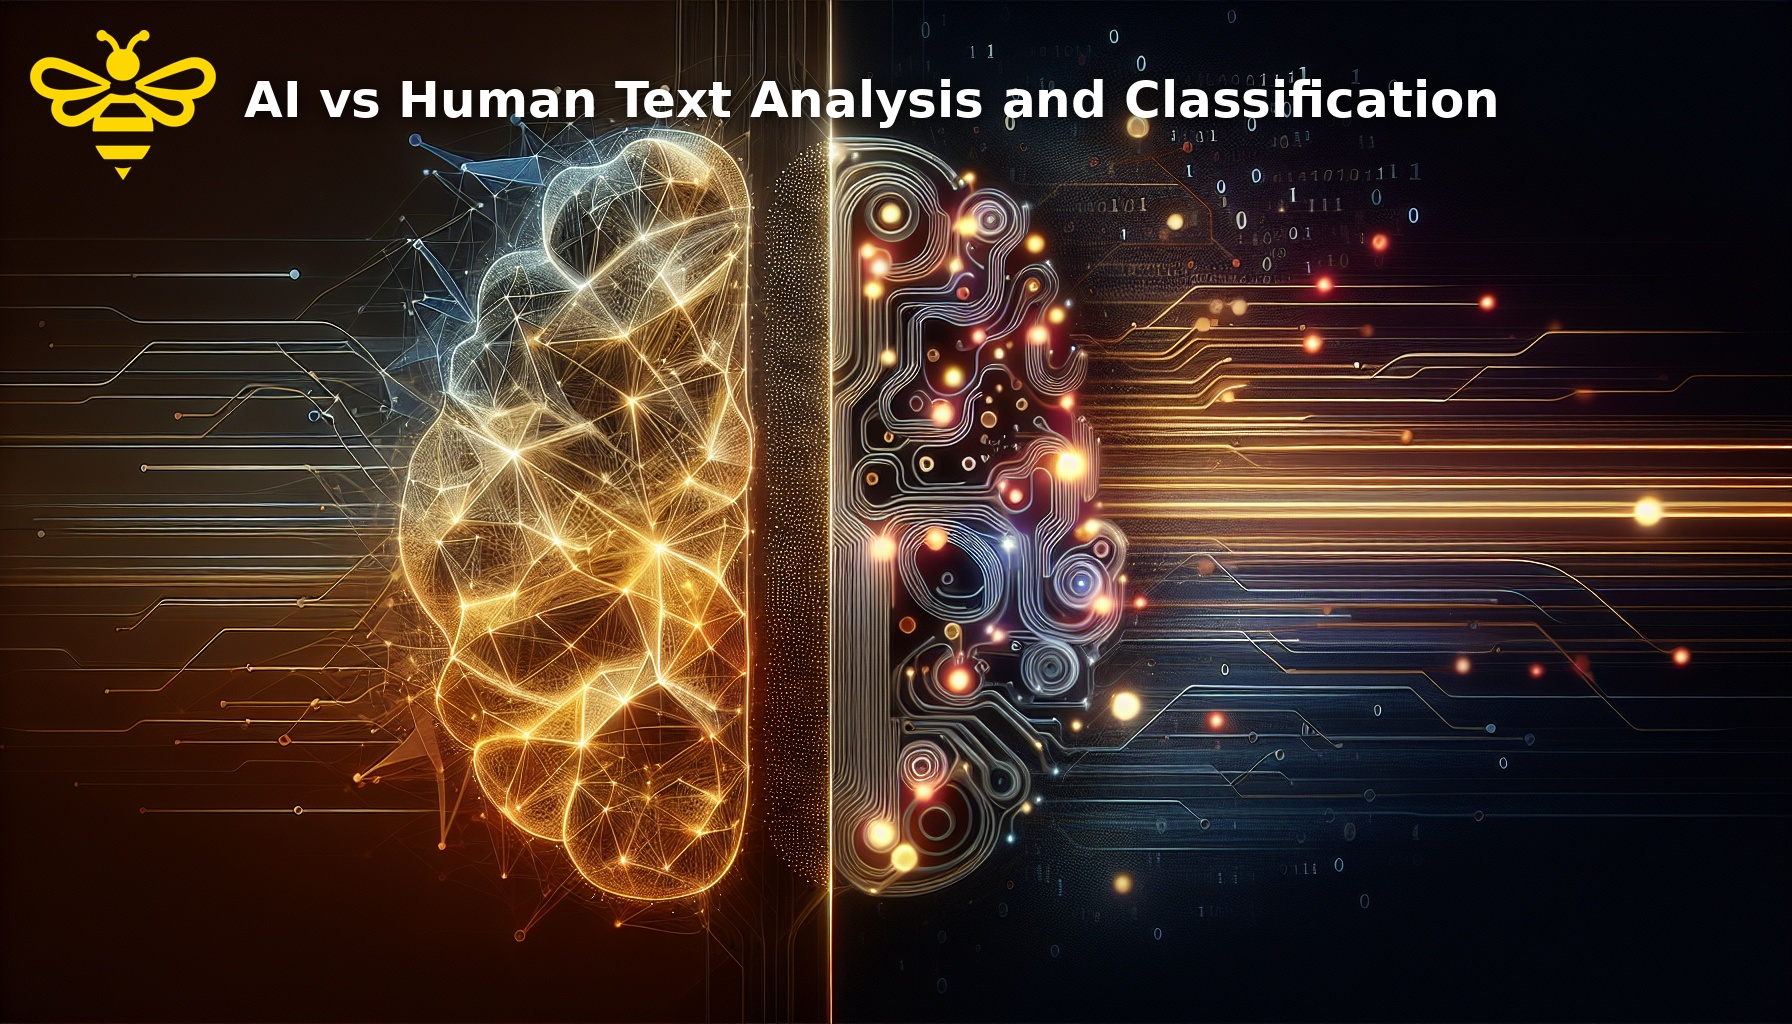

# Table of Content
>[Workflow in the Notebook](#scrollTo=gkBSloBMzj8N)

>[AI vs Human Text Classification](#scrollTo=pbt8sBCKWPfK)

>>[1. Exploratory Data Analysis (EDA)](#scrollTo=F1MEY3YAcDOJ)

>>[2. Text preprocessing](#scrollTo=eWK7AbzNfPdd)

>>[3. Machine Learning - Classsification](#scrollTo=YMHw5YGfrOTF)

>>>[3.1 Model Development](#scrollTo=UaIYLEPq2ySs)

>>>>[3.1.1 Logistic Regression](#scrollTo=1aN0X0hDNDw6)

>>>>[3.1.2 Support Vector Machine](#scrollTo=ONf8JvpD3BmG)

>>>>[3.1.3 Random Forest](#scrollTo=VTytVhv73EYv)

>>>>[3.1.4 XGBoost](#scrollTo=0sWmuhu33KKg)

>>>[3.2 Performance Evaluation](#scrollTo=-NNyZI_RFzCa)

>>>[3.3 Test Data](#scrollTo=yqoanxg9DH2w)

>>>>[3.3.1 Logistic Regression](#scrollTo=vv4KMsVeDXPZ)

>>>>[3.3.2 Support Vector Machine](#scrollTo=Yp_O-LVQDjNA)

>>>>[3.3.3 Random Forest](#scrollTo=v8b3Q2HSDntz)

>>>>[3.3.4 XGBoost](#scrollTo=2BqROhFtDqhO)



## **Workflow in the Notebook**

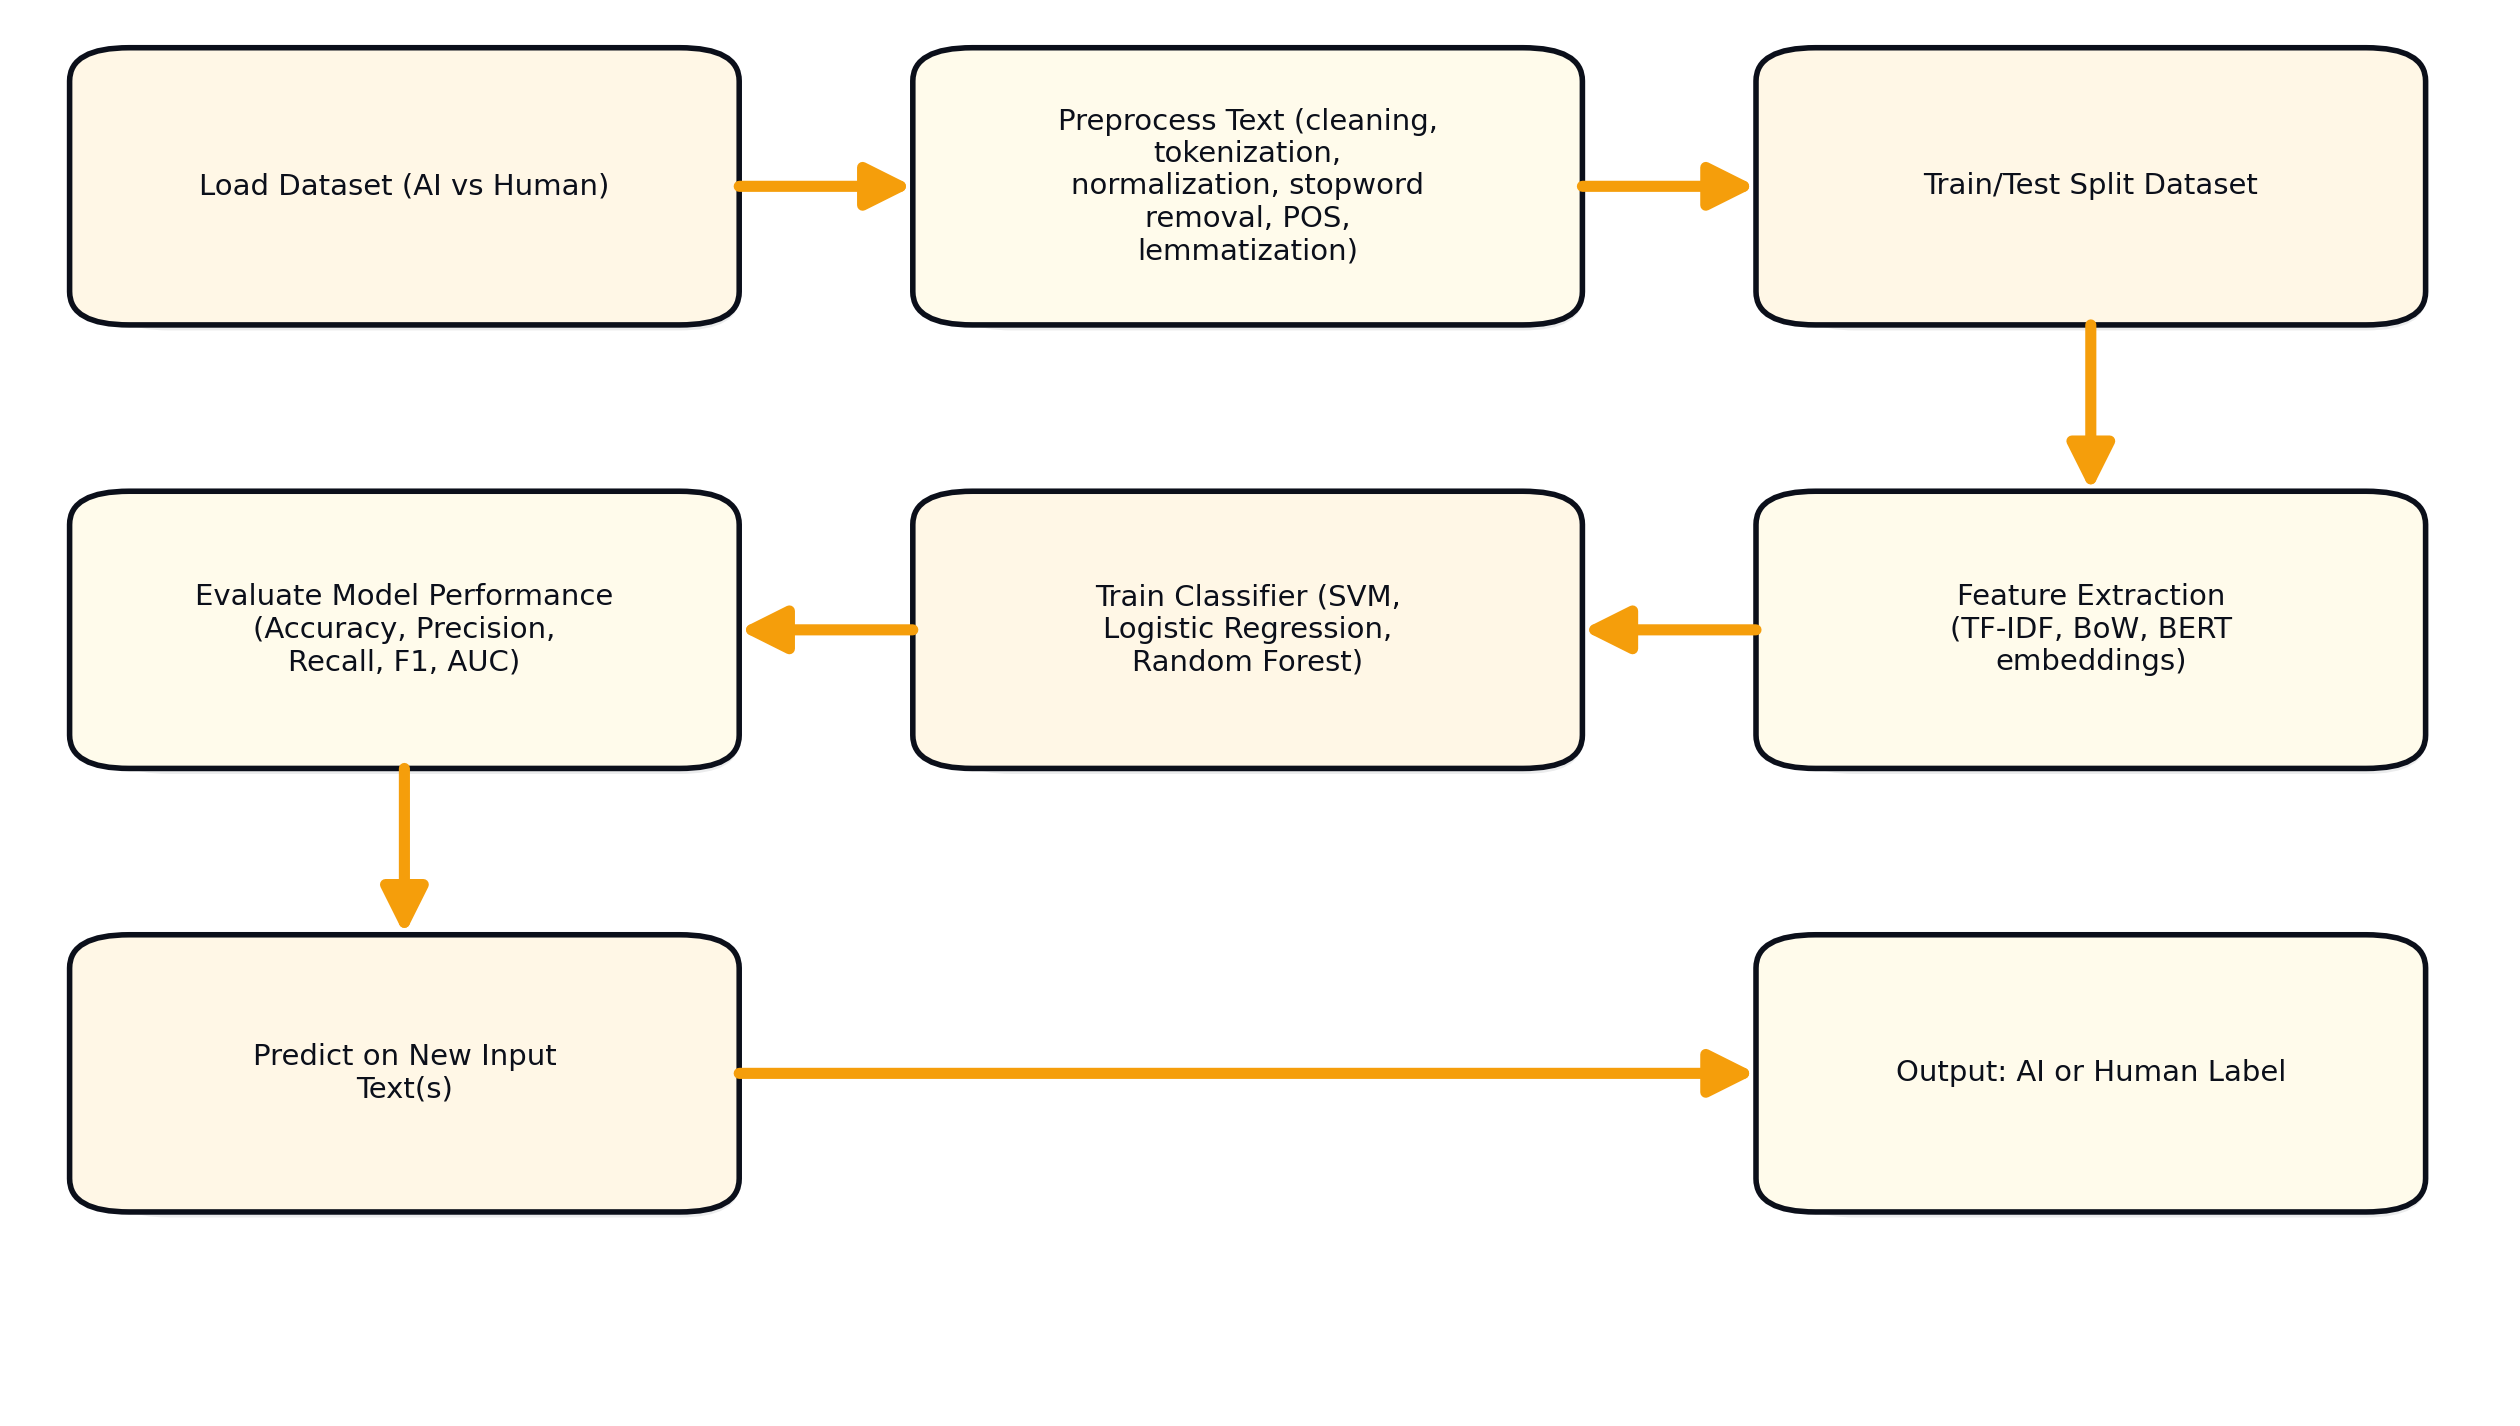

In [63]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
"""
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('all')
"""
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from inspect import ClassFoundException
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **AI vs Human Text Classification**

In [9]:
# Loading train and test data
df_train = pd.read_excel('/content/drive/MyDrive/Colab_Portfolio/project1_ai_human_text_classification/AI_vs_huam_train_dataset.xlsx')
df_test = pd.read_csv('/content/drive/MyDrive/Colab_Portfolio/project1_ai_human_text_classification/Final_test_data.csv')


In [62]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3728 entries, 0 to 3727
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   essay           3728 non-null   object
 1   label           3728 non-null   int64 
 2   processed_text  3728 non-null   object
dtypes: int64(1), object(2)
memory usage: 87.5+ KB


In [61]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869 entries, 0 to 868
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay           869 non-null    object 
 1   label           0 non-null      float64
 2   processed_text  869 non-null    object 
dtypes: float64(1), object(2)
memory usage: 20.5+ KB


In [58]:
df_train.head()

,essay,label,processed_text
0,International sports events require the most w...,0,international sport event require welltrained ...
1,Globalisation has become a significant aspect ...,0,globalisation become significant aspect world ...
2,There is an ever-increasing number of bullying...,0,everincreasing number bullying activity numero...
3,"It is commonly believed, that companies should...",0,commonly believe company dress code policy emp...
4,Despite knowing about the adverse effects of c...,0,despite know adverse effect climate change hum...


In [13]:
df_train.tail()

,essay,label
3723,I agree that successful people are willing to ...,1
3724,I believe that people who are open to trying n...,1
3725,"To succeed in life, we must do everything poss...",1
3726,"I'm not entirely sure what the word ""successfu...",1
3727,The key to success is trying new things while ...,1


In [14]:
# Check for leading whitespace in the 'essay' column in train data
leading_whitespace_check = df_train['essay'].apply(lambda x: x.startswith(' '))
print("Number of rows with leading whitespace:", leading_whitespace_check.sum())

Number of rows with leading whitespace: 0


In [15]:
df_test.head()

,essay,label
0,"Enjoyment means entertainment, satisfaction of...",NaN
1,Before to start with my opinion of the topic i...,NaN
2,"Thats a really really good subject, but acctul...",NaN
3,I disagree with the statement saying that it i...,NaN
4,It is undeniable that advertisements play a si...,NaN


In [16]:
df_test.tail()

,essay,label
864,Advertisements occupy a big part in our lives ...,NaN
865,Young people are the fundamental building bloc...,NaN
866,"In my opinion, and experience, old people can ...",NaN
867,I agree with this statement that most advertis...,NaN
868,It is undeniable that advertisements play a si...,NaN


In [17]:
# Check for leading whitespace in the 'essay' column in test data
leading_whitespace_check = df_test['essay'].apply(lambda x: x.startswith(' '))
print("Number of rows with leading whitespace:", leading_whitespace_check.sum())


Number of rows with leading whitespace: 0


## **1. Exploratory Data Analysis (EDA)**

In [18]:
# checking nulls
df_train.isna().sum()

,0
essay,0
label,0


In [19]:
df_test.isna().sum()

,0
essay,0
label,869


<Axes: xlabel='label'>

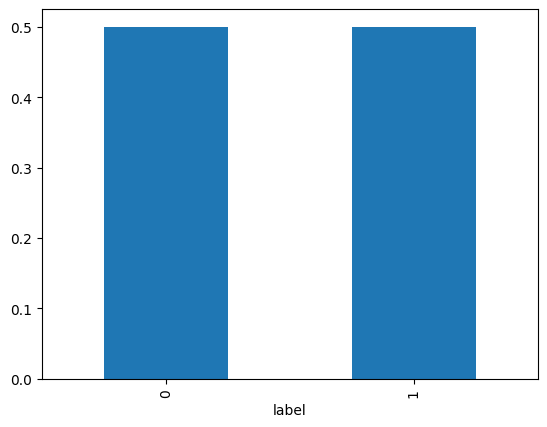

In [20]:
# checking class imbalance
df_train['label'].value_counts(normalize=True).plot.bar()

In [21]:
# create a list text_train
text_train = list(df_train['essay'])

##**2. Text preprocessing**


In [22]:
# Cleaning text with preprocessing+lemmatization

class text_process_lemmatize:
  """
  this class will help preprocess and lemmatize the text
  """
  def __init__(self):
      self.lemmatizer = WordNetLemmatizer()
      self.stop_words = set(stopwords.words('english'))

      # extended stopword list
      self.stop_words.update(["u", "ur", "4", "2", "im", "dont", "doin", "ure"])


  def preprocess_text(self,text):
        """
        this function will clean the text
        """
        # Exception handling
        if not isinstance(text,str):
            return ""

        # Converting the text to lowercase
        text = text.lower()

        # Removing emails, Urls, tags, extra spaces
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = ' '.join(text.split())

        # Removing special characters and punctuation
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        return text

  def get_pos_tag(self, word):
        """
        Convert POS tag to format accepted by WordNet lemmatizer
        """
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"JJ": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "RB": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

  def lemmatizer_text(self, text):
        """
        this function will lemmatize the text
        """
        tokens = word_tokenize(text)
        lemmatized_tokens = []
        for token in tokens:
            if token not in self.stop_words and len(token)>2:
                pos_tag_token=self.get_pos_tag(token)
                lemmatized_token = self.lemmatizer.lemmatize(token, pos_tag_token)
                lemmatized_tokens.append(lemmatized_token)

        return ' '.join(lemmatized_tokens)


  def preprocess(self, text):
        """
        this function will preprocess the text
        """
        preprocessed_text = self.preprocess_text(text)
        final_preprocessed_text = self.lemmatizer_text(preprocessed_text)
        return final_preprocessed_text



In [23]:
# initializing class textprocessor

pp = text_process_lemmatize()

In [24]:
# text processing train data
df_train['processed_text']= df_train['essay'].apply(pp.preprocess)

# text processing test data
df_test['processed_text']= df_test['essay'].apply(pp.preprocess)

print("essay column is now processed for both train and test data")

essay column is now processed for both train and test data


In [25]:
df_train.head()

,essay,label,processed_text
0,International sports events require the most w...,0,international sport event require welltrained ...
1,Globalisation has become a significant aspect ...,0,globalisation become significant aspect world ...
2,There is an ever-increasing number of bullying...,0,everincreasing number bullying activity numero...
3,"It is commonly believed, that companies should...",0,commonly believe company dress code policy emp...
4,Despite knowing about the adverse effects of c...,0,despite know adverse effect climate change hum...


In [26]:
df_test.head()

,essay,label,processed_text
0,"Enjoyment means entertainment, satisfaction of...",NaN,enjoyment mean entertainment satisfaction one ...
1,Before to start with my opinion of the topic i...,NaN,start opinion topic must say life much importa...
2,"Thats a really really good subject, but acctul...",NaN,thats really really good subject acctully say ...
3,I disagree with the statement saying that it i...,NaN,disagree statement say better broad knowledge ...
4,It is undeniable that advertisements play a si...,NaN,undeniable advertisement play significant role...


##**3. Machine Learning - Classsification**

In [27]:
X = df_train['processed_text']
y = df_train['label']



In [28]:
print("Total Samples :" , len(X))
print("Total Labels:", len(y))

Total Samples : 3728
Total Labels: 3728


In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=45)

In [30]:
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Training label distribution: {np.bincount(y_train)}")
print(f"Validation label distribution: {np.bincount(y_val)}")

Training samples: 2982
Validation samples: 746
Training label distribution: [1491 1491]
Validation label distribution: [373 373]


In [31]:
#using TF-IDF because we want informative tokens to matter more than ubiquitous ones
tfidf = TfidfVectorizer(
              max_features=None,
              ngram_range=(1,2),
              min_df=2,
              max_df=0.95,
              stop_words='english')

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

### **3.1 Model Development**

####3.1.1 Logistic Regression

In [32]:
lr = LogisticRegression()

lr.fit(X_train_tfidf, y_train)


# generate predictions

predictions_lr = lr.predict(X_val_tfidf)

predictions_lr

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,

In [33]:
# confusion matrix
df_lr = pd.DataFrame(metrics.confusion_matrix(y_val,predictions_lr), index=['Human','AI'], columns=['Human','AI'])


In [34]:
df_lr

,Human,AI
Human,348,25
AI,19,354


In [35]:
lr_accuracy = metrics.accuracy_score(y_val, predictions_lr)
lr_accuracy

0.9410187667560321

In [36]:
print(classification_report(y_val, lr.predict(X_val_tfidf)))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       373
           1       0.93      0.95      0.94       373

    accuracy                           0.94       746
   macro avg       0.94      0.94      0.94       746
weighted avg       0.94      0.94      0.94       746



####3.1.2 Support Vector Machine

In [37]:
clf = SVC()

clf.fit(X_train_tfidf, y_train)


# generate predictions

predictions_clf = clf.predict(X_val_tfidf)

predictions_clf

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,

In [38]:
# confusion matrix
df_svm = pd.DataFrame(metrics.confusion_matrix(y_val,predictions_clf), index=['Human','AI'], columns=['Human','AI'])
df_svm

,Human,AI
Human,343,30
AI,23,350


In [39]:
svm_accuracy = metrics.accuracy_score(y_val, predictions_clf)
print("support Vector Machine Accuracy : ",svm_accuracy)
print(classification_report(y_val, clf.predict(X_val_tfidf)))

support Vector Machine Accuracy :  0.9289544235924933
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       373
           1       0.92      0.94      0.93       373

    accuracy                           0.93       746
   macro avg       0.93      0.93      0.93       746
weighted avg       0.93      0.93      0.93       746



####3.1.3 Random Forest

In [40]:
rf = RandomForestClassifier()

rf.fit(X_train_tfidf, y_train)


# generate predictions

predictions_rf = rf.predict(X_val_tfidf)

In [41]:
# confusion matrix
df_rf = pd.DataFrame(metrics.confusion_matrix(y_val,predictions_rf), index=['Human','AI'], columns=['Human','AI'])
df_rf

,Human,AI
Human,342,31
AI,14,359


In [42]:
rf_accuracy = metrics.accuracy_score(y_val, predictions_rf)
print("Random Forest Accuracy : ",rf_accuracy)
print(classification_report(y_val, rf.predict(X_val_tfidf)))

Random Forest Accuracy :  0.9396782841823056
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       373
           1       0.92      0.96      0.94       373

    accuracy                           0.94       746
   macro avg       0.94      0.94      0.94       746
weighted avg       0.94      0.94      0.94       746



####3.1.4 XGBoost

In [43]:
xgb = xgb.XGBClassifier()

xgb.fit(X_train_tfidf, y_train)


# generate predictions

predictions_xgb = xgb.predict(X_val_tfidf)

In [44]:
# confusion matrix
df_xgb = pd.DataFrame(metrics.confusion_matrix(y_val,predictions_xgb), index=['Human','AI'], columns=['Human','AI'])
df_xgb

,Human,AI
Human,348,25
AI,19,354


In [45]:
xgb_accuracy = metrics.accuracy_score(y_val, predictions_xgb)
print("XGBoost Accuracy : ",xgb_accuracy)
print(classification_report(y_val, xgb.predict(X_val_tfidf)))

XGBoost Accuracy :  0.9410187667560321
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       373
           1       0.93      0.95      0.94       373

    accuracy                           0.94       746
   macro avg       0.94      0.94      0.94       746
weighted avg       0.94      0.94      0.94       746



###**3.2 Performance Evaluation**

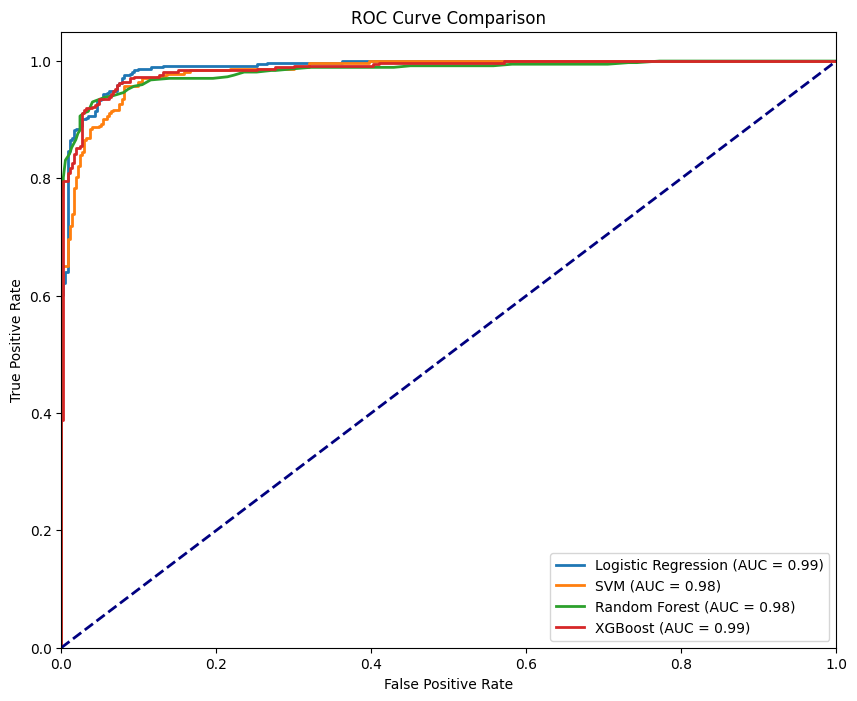

Logistic Regression: AUC - ROC = 0.99
SVM: AUC - ROC = 0.98
Random Forest: AUC - ROC = 0.98
XGBoost: AUC - ROC = 0.99


In [50]:
models = {
    "Logistic Regression": lr,
    "SVM": SVC(probability=True), # Added probability=True here
    "Random Forest": rf,
    "XGBoost": xgb
}
# Initialize a dictionary to store AUC - ROC scores
roc_auc_scores = {}

# Plot the ROC curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Predict the probabilities
    y_probs = model.predict_proba(X_val_tfidf)[:, 1]

    # Calculate the AUC - ROC score
    roc_auc = roc_auc_score(y_val, y_probs)
    roc_auc_scores[name] = roc_auc

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_probs)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# Print the AUC - ROC scores for each model
for name, score in roc_auc_scores.items():
    print(f'{name}: AUC - ROC = {score:.2f}')

In [57]:
# Print the AUC - ROC scores for each model
for name, score in roc_auc_scores.items():
    print(f'{name}: AUC - ROC = {score:.4f}')

Logistic Regression: AUC - ROC = 0.9889
SVM: AUC - ROC = 0.9825
Random Forest: AUC - ROC = 0.9829
XGBoost: AUC - ROC = 0.9854


### **3.3 Test Data**

In [51]:
X_test = df_test['processed_text']
X_test_tfidf = tfidf.transform(X_test)

####3.3.1 Logistic Regression

In [52]:
predictions_lr_test = lr.predict(X_test_tfidf)

####3.3.2 Support Vector Machine

In [53]:
predictions_svm_test = clf.predict(X_test_tfidf)

####3.3.3 Random Forest

In [55]:
predictions_rf_test = rf.predict(X_test_tfidf)

####3.3.4 XGBoost


In [56]:
predictions_xgb_test = xgb.predict(X_test_tfidf)

In [ ]:
# Storing all predictions to CSV

df_test['lr_pred'] = predictions_lr_test
df_test['svm_pred'] = predictions_svm_test
df_test['rf_pred'] = predictions_rf_test
df_test['xgb_pred'] = predictions_xgb_test

df_test.to_csv("final_test_pred.csv", index=False)